In [567]:
%config Completer.use_jedi = False


In [568]:
# Importamos las librerías

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold


In [569]:
pd.options.display.max_columns = None

# Modelos de Regresión y claificación para predicción de precio de autos

## Analisis exploratorio de datos

###  Leemos el dataset y hacemos un analisis exploratorio:
* Cantidad de columnas y nombres
* Tipo de dato para cada columna
* Analizar si hay duplicados y eliminarlos
* Analizar si hay datos faltantes, en que columna y tomar criterio para eliminacion o imputación

In [570]:
df_cars=pd.read_csv('ML_cars.csv')

In [571]:
df_cars.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [572]:
df_cars.head(2)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0


In [573]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

df_cars.isnull().sum()

#### registros duplicados : El dataset no tiene filas duplicadas

In [574]:
data_duplicates_df_cars =  df_cars.duplicated(subset=["car_ID"], keep="first")
print("registros duplicados en df_cars (car id): ", any(data_duplicates_df_cars))

registros duplicados en df_cars (car id):  False


#### registros nulos : El dataset no tiene filas con resgistros nulos

In [575]:
df_cars.isnull().sum().sum()

0

### Acondicionamiento de datos
* Reemplazamos en cylindernumber y doornumber los valores escritos por valores númericos
* Extraemos de la columna carName la marca del auto y elminamos el modelo que es muy especifico. 

In [576]:
df_cars.cylindernumber.unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

In [577]:
inicial = ['four', 'six', 'five', 'three', 'twelve', 'two', 'eight']
cambio= ['4','6','5','3','12','2','8']
dic = dict(zip(inicial, cambio))
# Realizar el reemplazo basado en el diccionario
df_cars['cylindernumber'] = df_cars['cylindernumber'].replace(dic)
df_cars['cylindernumber']=df_cars['cylindernumber'].astype(float)



In [578]:
inicialdoor = ['two','four']
cambiodoor= [2,4]
dicdoor = dict(zip(inicialdoor, cambiodoor))
# Realizar el reemplazo basado en el diccionario
df_cars['doornumber'] = df_cars['doornumber'].replace(dicdoor)
df_cars['doornumber']=df_cars['doornumber'].astype(float)

In [579]:
df_cars[['Marca', 'Modelo']] = df_cars['CarName'].str.split(' ', n=1, expand=True)
marcamal = ['alfa-romero','maxda','Nissan','porcshce','toyouta','vokswagen', 'volkswagen']
marcabien= ['alfa-romeo','mazda','nissan','porsche','toyota','vw','vw']
dicMarca = dict(zip(marcamal, marcabien))
# Realizar el reemplazo basado en el diccionario
df_cars['Marca'] = df_cars['Marca'].replace(dicMarca)

### Análisis descriptivo de variables numéricas
* Distribución
* máximos y minimos para identificar si hay valores outliers
* Analisis de correlacion entre features para detectar colinealidades
* Analisis de correlacion entre features y Price

In [580]:
variables_numericas = df_cars[['car_ID', 'symboling', 'wheelbase', 'doornumber',
       'carlength', 'carwidth', 'carheight', 'curbweight',
       'cylindernumber', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price']]

In [581]:
variables_numericas.describe()

,car_ID,symboling,wheelbase,doornumber,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,3.121951,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,0.994966,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,2.000000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,2.000000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,4.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,4.000000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,4.000000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### histogramas de variables numericas

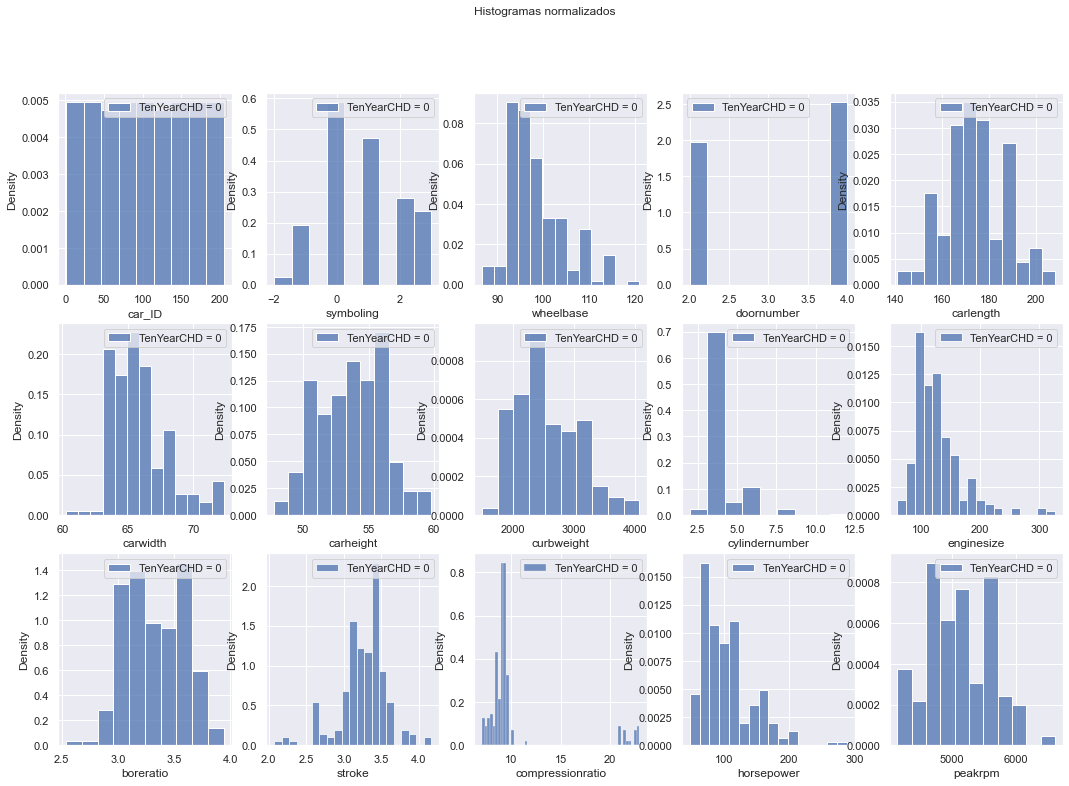

In [582]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,12))
fig.suptitle('Histogramas normalizados')
for c, ax in zip(variables_numericas.columns[:-1], axes.flatten()):
    sns.histplot(data = variables_numericas[c], stat = 'density', ax = ax, kde = False )
    ax.legend(['TenYearCHD = 0', 'TenYearCHD = 1'])

#### Boxplot de variables numéricas

In [583]:
variables_numericas_box1 = ['carlength', 'enginesize', 'horsepower']

In [584]:
variables_numericas_box2 =[ 'wheelbase', 'carwidth', 'carheight', 'citympg', 'highwaympg']

In [585]:
variables_numericas_box3 = [ 'curbweight','peakrpm']

In [586]:
variables_numericas_box4=['boreratio','stroke','compressionratio']

In [587]:
listas= [variables_numericas_box1,variables_numericas_box2,variables_numericas_box3,variables_numericas_box4]

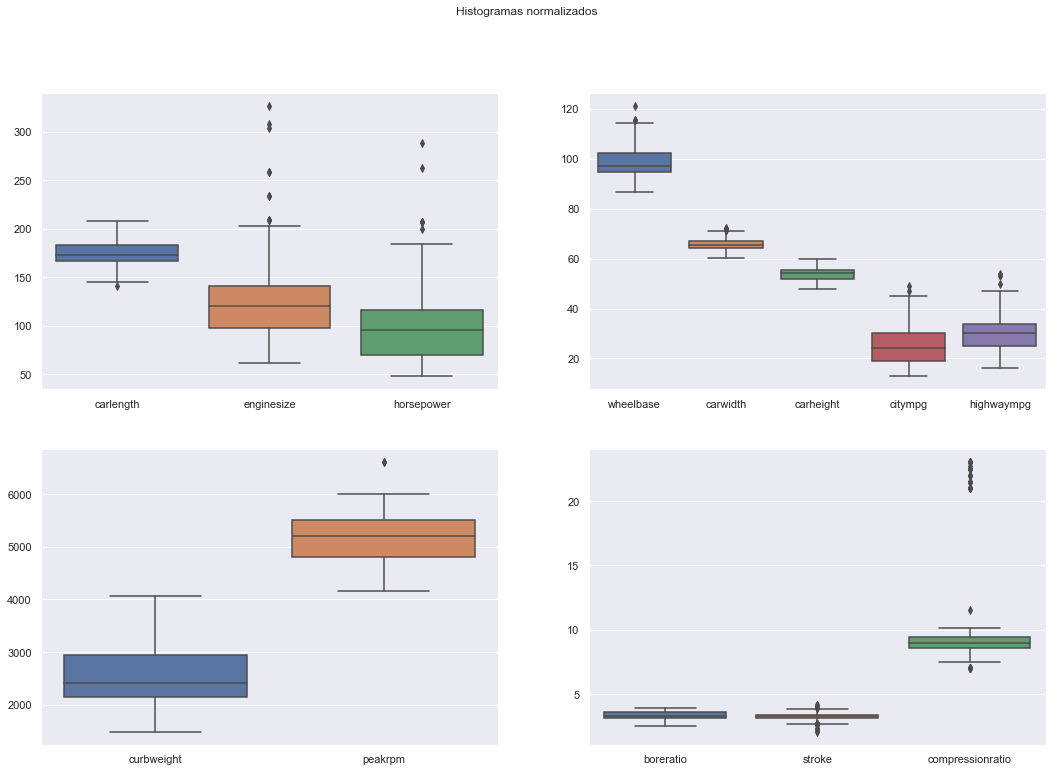

In [588]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
fig.suptitle('Histogramas normalizados')
for c, ax in zip(listas, axes.flatten()):
    sns.boxplot(data = variables_numericas[c], ax = ax)

#### Heatmap (Pearson) para identificar correlaciones entre features y features y target.

In [589]:
corr_variables_numericas = variables_numericas.corr()

<AxesSubplot:>

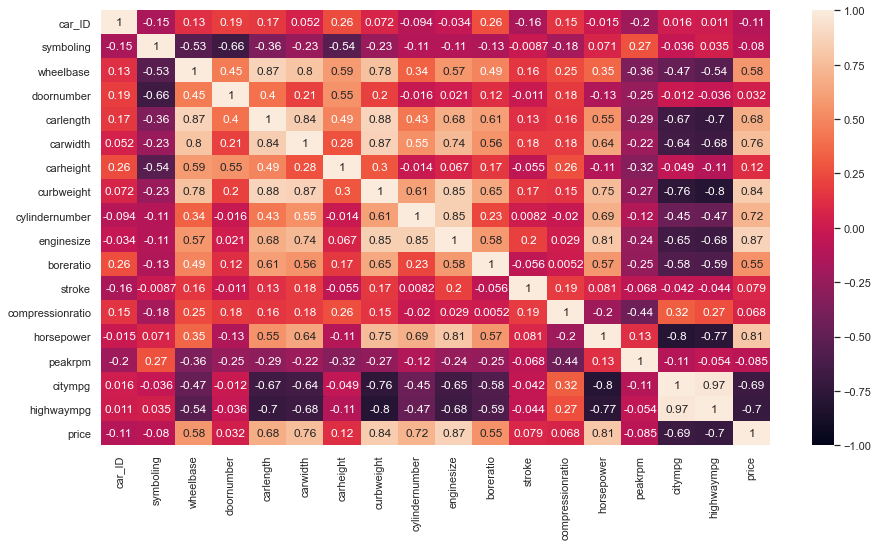

In [590]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_variables_numericas,annot=True, vmax=1,vmin=-1)

In [591]:
# features que estan correlacionadas entre ellas:
#carlength y wheelbase
# curbweigh, engine size, cylindernumber
# features que estan correlacionadas con el precio:
# 1 - 'enginesize'
# 2 - 'curbweight'
# 3 - 'horsepower' 
# 4 - 'carwidth'
# 5-  'cylindernumber'
#etc

### Analisis descriptivo de variables categoricas

In [592]:
variables_categoricas =['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'enginetype',
        'fuelsystem','Marca']

gas       185
diesel     20
Name: fueltype, dtype: int64


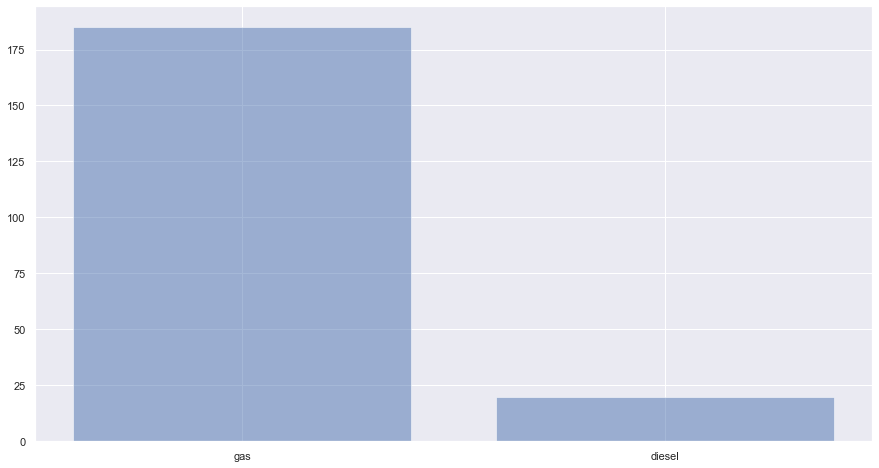

std      168
turbo     37
Name: aspiration, dtype: int64


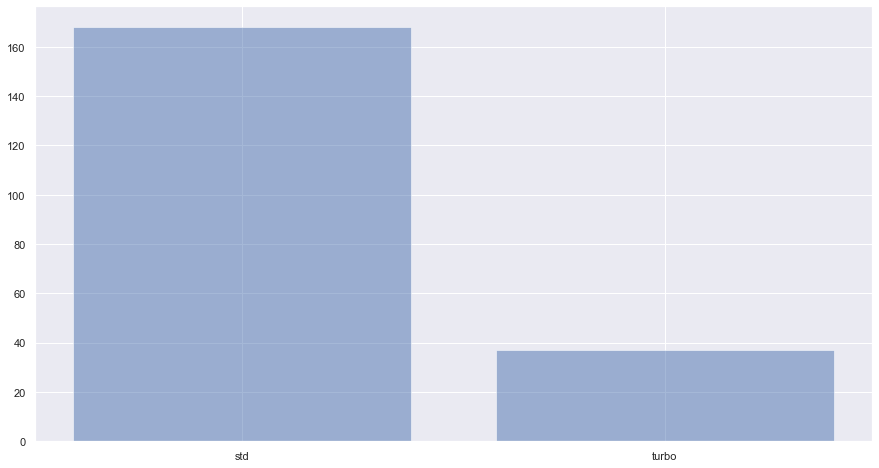

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64


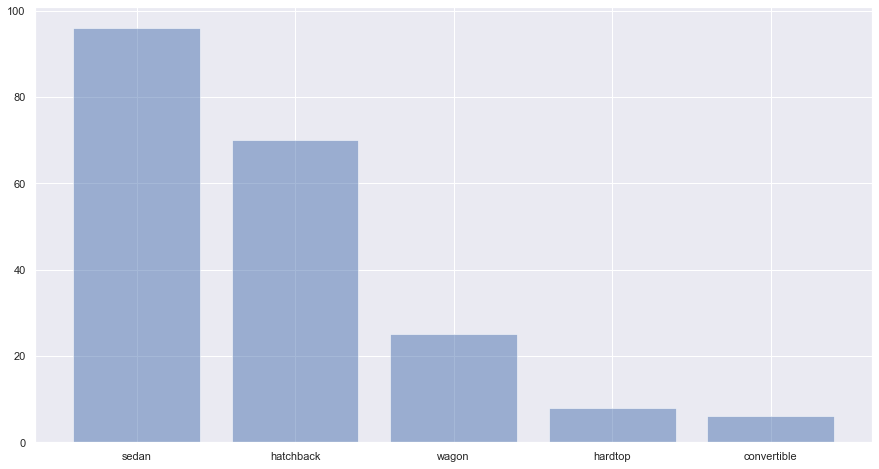

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64


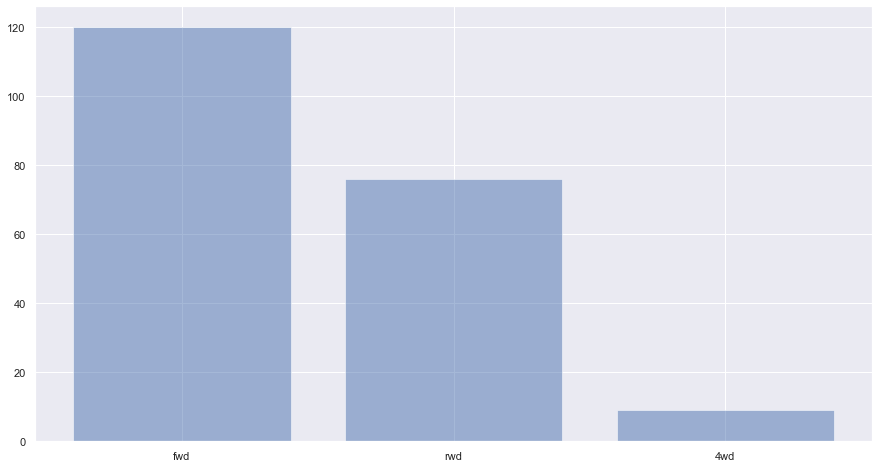

front    202
rear       3
Name: enginelocation, dtype: int64


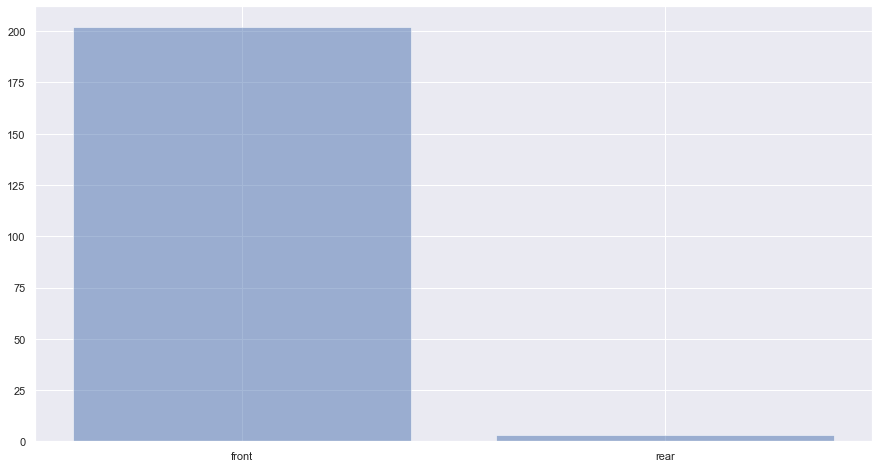

ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64


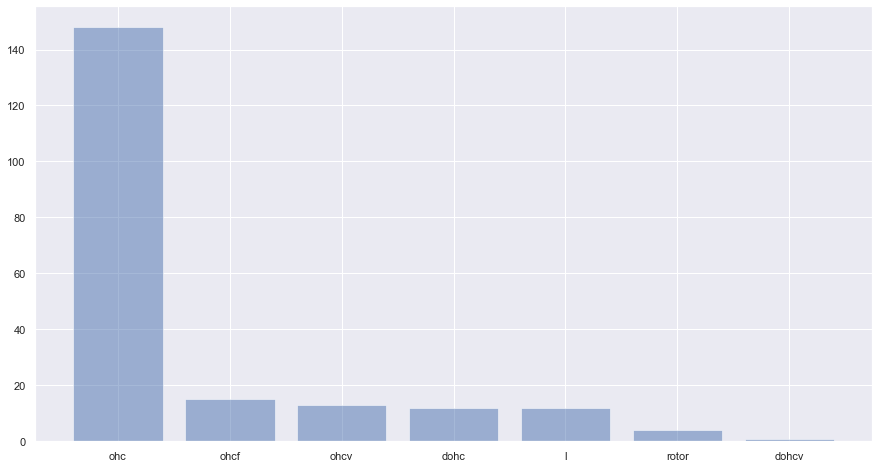

mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
spfi     1
mfi      1
Name: fuelsystem, dtype: int64


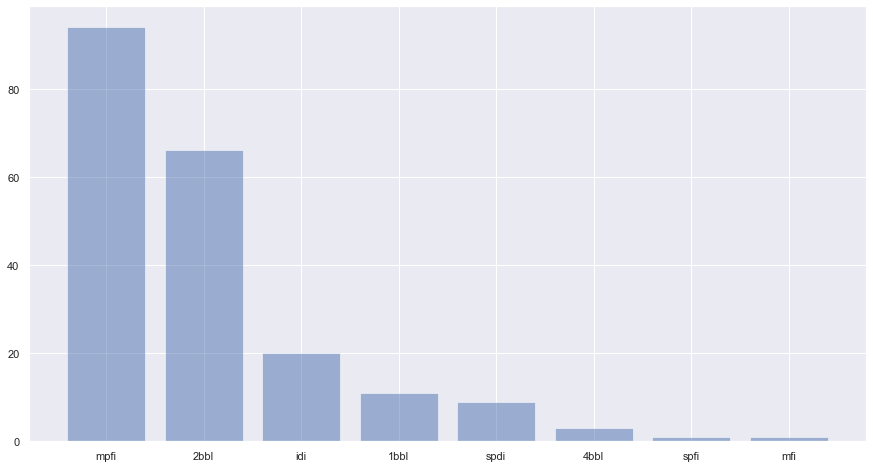

toyota        32
nissan        18
mazda         17
mitsubishi    13
honda         13
subaru        12
vw            12
peugeot       11
volvo         11
dodge          9
bmw            8
buick          8
plymouth       7
audi           7
saab           6
porsche        5
isuzu          4
alfa-romeo     3
chevrolet      3
jaguar         3
renault        2
mercury        1
Name: Marca, dtype: int64


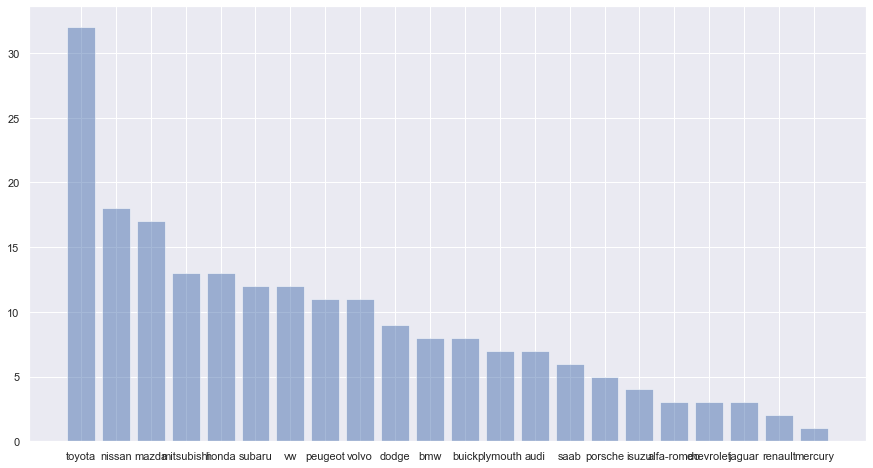

In [593]:
for category in variables_categoricas:
    print(df_cars[category].value_counts())
    plt.bar(df_cars[category].value_counts().index, df_cars[category].value_counts().values, color='b',\
            alpha=0.5)
    plt.show()

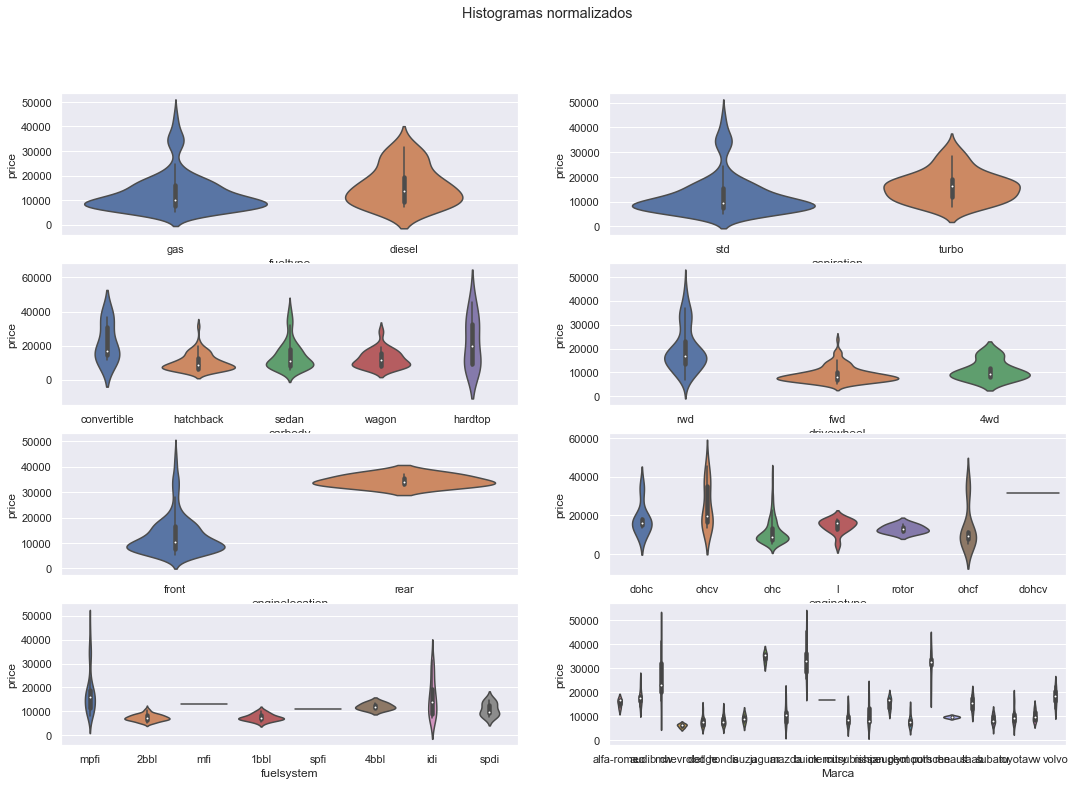

In [594]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,12))
fig.suptitle('Histogramas normalizados')
for c, ax in zip(variables_categoricas, axes.flatten()):
    sns.violinplot(data= df_cars, ax = ax, x=c, y='price')

In [595]:
# De los graficos se observa que las variables que afectan mas sobre el precio del auto son:  'enginelocation','Marca'

## Preparación de datos

#### Creación de variables dummies

In [596]:
dfCars= pd.get_dummies( df_cars,columns=variables_categoricas, 
                            drop_first = False, dtype=int)

In [597]:
dfCars

,car_ID,symboling,CarName,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,Modelo,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,Marca_alfa-romeo,Marca_audi,Marca_bmw,Marca_buick,Marca_chevrolet,Marca_dodge,Marca_honda,Marca_isuzu,Marca_jaguar,Marca_mazda,Marca_mercury,Marca_mitsubishi,Marca_nissan,Marca_peugeot,Marca_plymouth,Marca_porsche,Marca_renault,Marca_saab,Marca_subaru,Marca_toyota,Marca_volvo,Marca_vw
0,1,3,alfa-romero giulia,2.0,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,9.0,111,5000,21,27,13495.0,giulia,0,1,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,3,alfa-romero stelvio,2.0,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,9.0,111,5000,21,27,16500.0,stelvio,0,1,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,alfa-romero Quadrifoglio,2.0,94.5,171.2,65.5,52.4,2823,6.0,152,2.68,3.47,9.0,154,5000,19,26,16500.0,Quadrifoglio,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2,audi 100 ls,4.0,99.8,176.6,66.2,54.3,2337,4.0,109,3.19,3.40,10.0,102,5500,24,30,13950.0,100 ls,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2,audi 100ls,4.0,99.4,176.6,66.4,54.3,2824,5.0,136,3.19,3.40,8.0,115,5500,18,22,17450.0,100ls,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),4.0,109.1,188.8,68.9,55.5,2952,4.0,141,3.78,3.15,9.5,114,5400,23,28,16845.0,145e (sw),0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
201,202,-1,volvo 144ea,4.0,109.1,188.8,68.8,55.5,3049,4.0,141,3.78,3.15,8.7,160,5300,19,25,19045.0,144ea,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
202,203,-1,volvo 244dl,4.0,109.1,188.8,68.9,55.5,3012,6.0,173,3.58,2.87,8.8,134,5500,18,23,21485.0,244dl,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
203,204,-1,volvo 246,4.0,109.1,188.8,68.9,55.5,3217,6.0,145,3.01,3.40,23.0,106,4800,26,27,22470.0,246,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [598]:
dfCars.columns

Index(['car_ID', 'symboling', 'CarName', 'doornumber', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'Modelo',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'fuelsystem_1bbl', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'Marca_alfa-romeo', 'Marca_audi',
       'Marca_bmw', 'Marca_buick', 'Marca_chevrolet', 'Marca_dodge

## Modelo de Regresion lineal para predicción del precio del auto

In [599]:
# Creamos X e y

feature_cols = ['symboling', 'doornumber',
       'carlength','carwidth', 'carheight', 'curbweight', 'cylindernumber',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'fuelsystem_1bbl', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'Marca_alfa-romeo', 'Marca_audi',
       'Marca_bmw', 'Marca_buick', 'Marca_chevrolet', 'Marca_dodge',
       'Marca_honda', 'Marca_isuzu', 'Marca_jaguar', 'Marca_mazda',
       'Marca_mercury', 'Marca_mitsubishi', 'Marca_nissan', 'Marca_peugeot',
       'Marca_plymouth', 'Marca_porsche', 'Marca_renault', 'Marca_saab',
       'Marca_subaru', 'Marca_toyota', 'Marca_volvo', 'Marca_vw']


#### Generamos matriz de features y precio

In [600]:
X = dfCars[feature_cols]
y = dfCars.price

In [601]:

from sklearn import metrics

#### modelo de regesion Lineal

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42) 
modelo_l = linear_model.LinearRegression()
modelo_l.fit(X_train, y_train)
from sklearn import metrics

y_pred=modelo_l.predict(X_test)
print ('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print ('MSE:', metrics.mean_squared_error(y_test, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2:', metrics.r2_score(y_test, y_pred))

MAE: 1945.464364391433
MSE: 8337008.511211824
RMSE: 2887.387835260761
R2: 0.8796697224061585


#### modelo de regresion lineal con cross validation

In [603]:
def regresion(feature_cols):

    X = dfCars[feature_cols]
    y = dfCars.price
 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
    pepe = linear_model.LinearRegression()
    
 
    pepe.fit(X_train, y_train)
 
    score = pepe.score(X_train,y_train)
 
    print("Metrica del modelo sin cross validation", score)
    
    kf = KFold(n_splits=7, shuffle=True, random_state=68)
 
    cv_scores = cross_val_score(pepe, X_train, y_train, cv=kf)
    
    cv_scores = [round(num, 3) for num in cv_scores]
    print('Se obtienen los siguientes coeficientes de determinación con cross validation:')
    print(cv_scores)
    print(f'Max R-Squared: {max(cv_scores)}')
    print(f'Min R-Squared: {min(cv_scores)}')
    print('Promedio R-Squared: {:.3f}'.format(np.mean(cv_scores)))
    print('Desviación Estándar: {:.3f}'.format(np.std(cv_scores)))
    print(f'Intervalo de confianza 95%: {np.quantile(cv_scores, [0.025, 0.975])}', '\n')
 
    y_pred = pepe.predict(X_test)
    print ('Metricas en Test')
    print ('Test MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('Test MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('test R2:', metrics.r2_score(y_test, y_pred))

In [604]:
regresion(feature_cols)

Metrica del modelo sin cross validation 0.9717488874560091
Se obtienen los siguientes coeficientes de determinación con cross validation:
[0.81, 0.906, 0.869, 0.883, 0.922, 0.951, 0.935]
Max R-Squared: 0.951
Min R-Squared: 0.81
Promedio R-Squared: 0.897
Desviación Estándar: 0.044
Intervalo de confianza 95%: [0.81885 0.9486 ] 

Metricas en Test
Test MAE: 1981.9277034349368
Test MSE: 9542382.701332387
Test RMSE: 3089.0747322349434
test R2: 0.8767394524817969


features que estan correlacionadas entre ellas:
  * carlength y wheelbase
  * curbweigh, engine size, cylindernumber

In [605]:
feature_cols_sin_colinealiedades = ['symboling','doornumber', 'wheelbase',
       'carwidth', 'carheight', 'curbweight',
       'boreratio', 'stroke', 'compressionratio',
       'peakrpm', 'citympg', 
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std', 'aspiration_turbo',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_front', 'enginelocation_rear',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'fuelsystem_1bbl', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'Marca_alfa-romeo', 'Marca_audi',
       'Marca_bmw', 'Marca_buick', 'Marca_chevrolet', 'Marca_dodge',
       'Marca_honda', 'Marca_isuzu', 'Marca_jaguar', 'Marca_mazda',
       'Marca_mercury', 'Marca_mitsubishi', 'Marca_nissan', 'Marca_peugeot',
       'Marca_plymouth', 'Marca_porsche', 'Marca_renault', 'Marca_saab',
       'Marca_subaru', 'Marca_toyota', 'Marca_volvo', 'Marca_vw']

In [606]:
regresion(feature_cols_sin_colinealiedades)

Metrica del modelo sin cross validation 0.9650581584784279
Se obtienen los siguientes coeficientes de determinación con cross validation:
[0.834, 0.832, 0.862, 0.903, 0.94, 0.92, 0.94]
Max R-Squared: 0.94
Min R-Squared: 0.832
Promedio R-Squared: 0.890
Desviación Estándar: 0.044
Intervalo de confianza 95%: [0.8323 0.94  ] 

Metricas en Test
Test MAE: 1928.3614152415673
Test MSE: 11972090.813831074
Test RMSE: 3460.070926127248
test R2: 0.8453545079003778


#### Probamos regularizacion

In [607]:
# Ahora entrenamos el modelo con todas las variables con Ridge:

kf = KFold(n_splits=7, shuffle=True, random_state=68)

lm_ridge = linear_model.RidgeCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize=True) 
# Definimos el rango de de búsqueda del hiperparametro explicitamente

Regu_Ridge = lm_ridge.fit(X_train, y_train)

print('Regu_Ridge:', Regu_Ridge.score(X_test, y_test))

Regu_Ridge: 0.8643665199406534


### Conclusiones: 
* Se realizó un modelo de Regresion lineal multiple sin utilizar cross validation el resulltado de R2 fue: 0.8796697224061585
* Realizando cross validation dentro del conjunto de datos de Train obtuvimos un R2 promedio de: 0.890 y en el test 0.845
* Aplicamos la regularización de Ridge y obtuvimos un R2 en el test de 0.8643

#### Tanto en el modelo de regresion linal multiple como en el modelo con regularizacion se obtuvieron valores de R2 buenos y similares.

## Modelo de calsificacion para identificar si un auto es de gama alta o baja


In [608]:
dfCars_cl=dfCars

#### Generamos una columna que corresponda a la gama del auto utilizando la mediana como punto de corte.

In [609]:
medianaPrice=dfCars_cl['price'].median()
medianaPrice

10295.0

In [610]:
condicion = lambda x: 1 if x > medianaPrice else 0
dfCars_cl['gama'] = dfCars_cl.apply(lambda x: '1' if x['price']>medianaPrice else '0',axis=1)

In [611]:
dfCars_cl['gama']= dfCars_cl['gama'].astype(float)

In [612]:
X = dfCars[feature_cols]
y = dfCars.gama

#### Importamos las librerias necesarias para probar 3 modelos: 
* Regresion logistica
* Vecinos Cercanos
* Arbol de decisión

In [613]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.preprocessing import normalize

#### Generamos los datos de train y test

In [614]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Escalamos los datos

In [615]:
# Utilizamos sklearn para estandarizar la matriz de Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### Para analizar la performance de los 3 modelos vamos a: 
* realizar dos listas, una con los estimadores de los modelos y otra con la grid de parámetros a estimar en cada modelo.
y luego iterar sobre esas listas para estimar los hiperparámetros de los modelos

In [616]:
models = [LogisticRegression(),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]

In [617]:
params = [
    {'C': [1, 10, 100, 1000],
     'penalty': ['l1', 'l2',],
     'solver': ['saga']},
    {'n_neighbors': range(1,50),
     'weights' : ['uniform', 'distance'],
     'p' : [1, 2, 3]},
    { "criterion" : ["gini", "entropy"],
      "min_samples_leaf": [5,10,15,20,None], 
      "max_depth" : [1,3,4,5,8,9,10,11,12,13,14,None],
      "min_samples_split": [2, 3, 4,None]}
]

In [618]:
from sklearn.model_selection import StratifiedKFold
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [619]:
grids = []
for i in range(len(models)):
    gs = GridSearchCV(estimator=models[i], param_grid=params[i], scoring='accuracy', cv=folds, n_jobs=4)
    print (gs)
    fit = gs.fit(X_train, y_train)
    grids.append(fit)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['saga']},
             scoring='accuracy')


C:\Users\silde\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': range(1, 50), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14,
                                       None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')


#### vemos cuales fueron los mejores metricas del gridsearch

In [620]:
for i in grids:
    print (i.best_score_)
    print (i.best_estimator_)
    print (i.best_params_)

0.9264705882352942
LogisticRegression(C=1, solver='saga')
{'C': 1, 'penalty': 'l2', 'solver': 'saga'}
0.9018382352941178
KNeighborsClassifier(n_neighbors=1, p=1)
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.9209558823529411
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10)
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2}


#### Vemos los resultados de la validación cruzada para obtención la hiperparametros

In [621]:
pd.DataFrame(grids[0].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020619,0.004598,0.000740,0.000627,1,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.941176,0.941176,1.000000,0.941176,0.8125,0.9375,0.9375,0.9375,0.875,0.875,0.919853,0.049265,6
1,0.018164,0.002047,0.000603,0.000492,1,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8750,1.0000,0.9375,0.9375,0.875,0.875,0.926471,0.038030,1
2,0.023300,0.002575,0.000594,0.000613,10,l1,saga,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8125,0.9375,0.9375,0.9375,0.875,0.875,0.913971,0.042374,7
3,0.017459,0.002779,0.000737,0.000489,10,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8125,0.9375,0.9375,0.9375,0.875,0.875,0.913971,0.042374,7
4,0.023373,0.004133,0.000599,0.000489,100,l1,saga,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8750,0.9375,0.9375,0.9375,0.875,0.875,0.920221,0.029643,2
5,0.018133,0.001622,0.000542,0.000553,100,l2,saga,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8750,0.9375,0.9375,0.9375,0.875,0.875,0.920221,0.029643,2
6,0.020604,0.003028,0.000534,0.000537,1000,l1,saga,"{'C': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8750,0.9375,0.9375,0.9375,0.875,0.875,0.920221,0.029643,2
7,0.016524,0.002483,0.000489,0.000608,1000,l2,saga,"{'C': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.941176,0.941176,0.941176,0.941176,0.8750,0.9375,0.9375,0.9375,0.875,0.875,0.920221,0.029643,2


In [622]:
pd.DataFrame(grids[1].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001425,0.000504,0.002191,0.000715,1,1,uniform,"{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}",0.882353,0.941176,0.882353,1.000000,0.8750,1.0000,0.8125,0.8750,0.8750,0.8750,0.901838,0.056957,1
1,0.001736,0.000463,0.001863,0.000570,1,1,distance,"{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}",0.882353,0.941176,0.882353,1.000000,0.8750,1.0000,0.8125,0.8750,0.8750,0.8750,0.901838,0.056957,1
2,0.001251,0.000384,0.002284,0.000442,1,2,uniform,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.882353,0.941176,0.941176,0.941176,0.8750,0.9375,0.7500,0.8750,0.8125,0.8125,0.876838,0.063641,37
3,0.001386,0.000434,0.001349,0.000451,1,2,distance,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",0.882353,0.941176,0.941176,0.941176,0.8750,0.9375,0.7500,0.8750,0.8125,0.8125,0.876838,0.063641,37
4,0.001550,0.000550,0.004244,0.000755,1,3,uniform,"{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}",0.941176,0.941176,0.941176,0.941176,0.9375,0.9375,0.7500,0.8750,0.8125,0.8125,0.888971,0.068422,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.001642,0.000571,0.001971,0.000483,49,1,distance,"{'n_neighbors': 49, 'p': 1, 'weights': 'distan...",0.882353,0.941176,0.823529,0.882353,0.6875,1.0000,0.8750,0.9375,0.8750,0.7500,0.865441,0.087485,69
290,0.001491,0.000567,0.002319,0.000719,49,2,uniform,"{'n_neighbors': 49, 'p': 2, 'weights': 'uniform'}",0.882353,1.000000,0.882353,0.882353,0.6875,0.9375,0.6250,0.9375,0.8750,0.6875,0.839706,0.119981,137
291,0.001712,0.000520,0.002098,0.000419,49,2,distance,"{'n_neighbors': 49, 'p': 2, 'weights': 'distan...",0.882353,0.941176,0.882353,0.882353,0.6875,0.9375,0.6250,0.8750,0.8750,0.6875,0.827574,0.108981,182
292,0.001303,0.000401,0.005189,0.000956,49,3,uniform,"{'n_neighbors': 49, 'p': 3, 'weights': 'uniform'}",0.705882,0.882353,0.823529,0.588235,0.6250,0.6875,0.6250,0.7500,0.8125,0.6250,0.712500,0.095741,290


In [623]:
pd.DataFrame(grids[2].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001097,0.000470,0.000553,0.000568,gini,1,5,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.764706,0.941176,0.882353,0.823529,0.6875,0.9375,0.8125,0.875,0.875,0.8125,0.841176,0.073947,211
1,0.001059,0.000471,0.000301,0.000460,gini,1,5,3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.764706,0.941176,0.882353,0.823529,0.6875,0.9375,0.8125,0.875,0.875,0.8125,0.841176,0.073947,211
2,0.001142,0.000194,0.000357,0.000556,gini,1,5,4,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.764706,0.941176,0.882353,0.823529,0.6875,0.9375,0.8125,0.875,0.875,0.8125,0.841176,0.073947,211
3,0.001028,0.000379,0.000000,0.000000,gini,1,5,None,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379
4,0.001008,0.000006,0.000433,0.000535,gini,1,10,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.764706,0.941176,0.882353,0.823529,0.6875,0.9375,0.8125,0.875,0.875,0.8125,0.841176,0.073947,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.000855,0.000435,0.000000,0.000000,entropy,None,20,None,"{'criterion': 'entropy', 'max_depth': None, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299
476,0.001188,0.000340,0.000000,0.000000,entropy,None,None,2,"{'criterion': 'entropy', 'max_depth': None, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303
477,0.001401,0.001583,0.000000,0.000000,entropy,None,None,3,"{'criterion': 'entropy', 'max_depth': None, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305
478,0.000784,0.000527,0.000000,0.000000,entropy,None,None,4,"{'criterion': 'entropy', 'max_depth': None, 'm...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469


#### Ahora vamos a probar los modelos con los datos de x_test para evaluar la performance

In [624]:
X_test = scaler.transform(X_test)

In [625]:
y_preds_log = grids[0].predict(X_test)
y_preds_knn = grids[1].predict(X_test)
y_preds_tree = grids[2].predict(X_test)

#### Resultados de modelo de regresion logistica

In [626]:
print (classification_report(y_test, y_preds_log))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        21
         1.0       0.85      0.85      0.85        20

    accuracy                           0.85        41
   macro avg       0.85      0.85      0.85        41
weighted avg       0.85      0.85      0.85        41



In [627]:
confusion_matrix(y_test, y_preds_log)

array([[18,  3],
       [ 3, 17]], dtype=int64)

#### Resultados de modelo de regresion KNN

In [628]:
print (classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91        21
         1.0       0.94      0.85      0.89        20

    accuracy                           0.90        41
   macro avg       0.91      0.90      0.90        41
weighted avg       0.91      0.90      0.90        41



In [629]:
confusion_matrix(y_test, y_preds_knn)

array([[20,  1],
       [ 3, 17]], dtype=int64)

#### Resultados de modelo de regresion arbol

In [630]:
print (classification_report(y_test, y_preds_tree))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.82      0.90      0.86        20

    accuracy                           0.85        41
   macro avg       0.86      0.85      0.85        41
weighted avg       0.86      0.85      0.85        41



In [631]:
confusion_matrix(y_test, y_preds_tree)

array([[17,  4],
       [ 2, 18]], dtype=int64)

####  Analizamos curva ROC y Auc para cada modelo

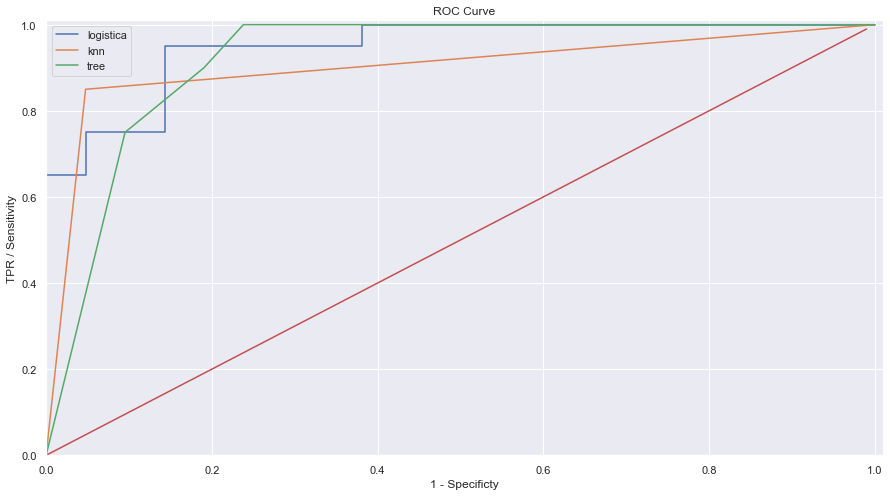

In [632]:
# ROC Curve y AUC
y_pred_proba_log = grids[0].predict_proba(X_test)
y_pred_proba_knn = grids[1].predict_proba(X_test)
y_pred_proba_tree = grids[2].predict_proba(X_test)



from sklearn.metrics import roc_curve
fpr_l,tpr_l,thr_l = roc_curve(y_test, y_pred_proba_log[:,1])
fpr_k,tpr_k,thr_k = roc_curve(y_test, y_pred_proba_knn[:,1])
fpr_t,tpr_t,thr_t = roc_curve(y_test, y_pred_proba_tree[:,1])


df_l = pd.DataFrame(dict(fpr=fpr_l, tpr=tpr_l, thr = thr_l))
df_k = pd.DataFrame(dict(fpr=fpr_k, tpr=tpr_k, thr = thr_k))
df_t = pd.DataFrame(dict(fpr=fpr_t, tpr=tpr_t, thr = thr_t))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df_l['fpr'],df_l['tpr'])
plt.plot(df_k['fpr'],df_k['tpr'])
plt.plot(df_t['fpr'],df_t['tpr'])
plt.legend(['logistica','knn','tree'])

plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [633]:
from sklearn.metrics import auc
print('AUC log=', auc(fpr_l, tpr_l))
print('AUC knn=', auc(fpr_k, tpr_k))
print('AUC tree=', auc(fpr_t, tpr_t))

AUC log= 0.9476190476190476
AUC knn= 0.9011904761904762
AUC tree= 0.9214285714285714


#### Conclusiones:
* Se compararon 3 modelos de clasificación : regresion logistica, Knn y arbol de decisión.
* Como las clases estan balanceadas el accurancy resulta una buena metrica para la evaluación. El modelo KNN es el que presenta el valor de accurancy mas alto de 0.9.
* Al analizar las curvas ROC y el parametro AUC, el modelo de regresion logistica es que le persentó mejor performance.
* Todos los modelos arrojaron buenos resultados de prformance.